Maltose Binding Kinetics Calculation
=====


Data obtained from Molecular Dynamics (MD, can be viewed as a sampling method)

In [1]:
from IPython.display import HTML, Image
HTML("""
<video width='480' height='480' controls>
    <source src='./trans1.mov'>
</video>
""")

In essense, regular MD data is time series data--trajectory x(t)

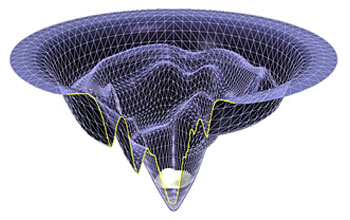

In [2]:
Image("/Users/Yvonne/Research/mbp/funnel-landscape.jpg")

In [3]:
import pyemma
import numpy as np
import matplotlib.pyplot as plt
import pyemma.msm as msm
import pyemma.plots as mplt
import pyemma.coordinates as coor
%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/Users/Yvonne/miniconda3/lib/python3.5/site-packages/pyemma/__init__.py:130: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.4, you have 2.5.1.
  .format(latest=latest, current=current), category=UserWarning)


Load MD data
=====


Based on our understanding of the system, two metrics-Ligand RMSD and Closure Angle are used instead of using dimension reduction algorithms like t-SNE.

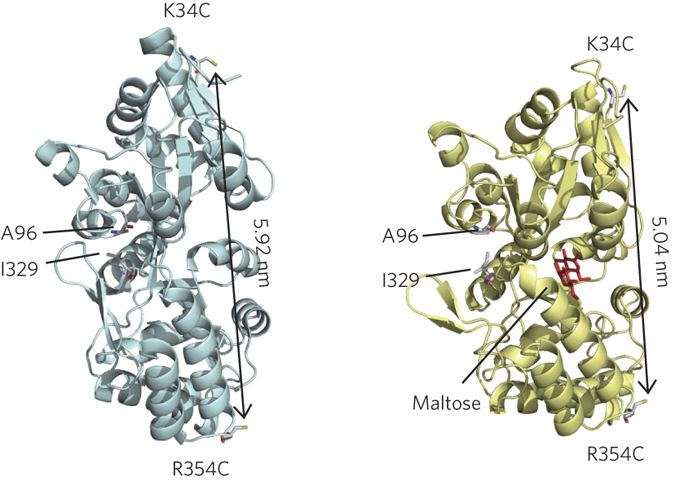

In [4]:
Image("/Users/Yvonne/Research/mbp/nchembio-mbp.jpg")

In [5]:
md_trajs=[]
with open('filename-all-0126', 'r') as myfile:
    flnm=myfile.read().replace('\n', ' ')
flist=flnm.split()

In [6]:
for f in flist:
    ligrmsd_file='./short-set/mal-rmsd/mal-'+f+'.rmsd'
    angle_file='./short-set/angle-cacom/cacom-'+f+'.angle'
    mal_rmsd=np.loadtxt(ligrmsd_file,skiprows=1,usecols=[1])
    mbp_angle=np.loadtxt(angle_file,skiprows=1,usecols=[1])
    sample=np.vstack((mal_rmsd, mbp_angle))
    sample=sample.transpose()
    md_trajs.append(sample)

In [7]:
len(md_trajs)

493

# Markov state modeling

Basic idea: estimate transition probability matrix through building Markov chain  

Step 1. Define microstates-unsupervised learning.     
  
Step 2. Count transition times among microstates.     
  
Step 3. Use Maximum Likelihood to estimate transition probabilities among microstates.  

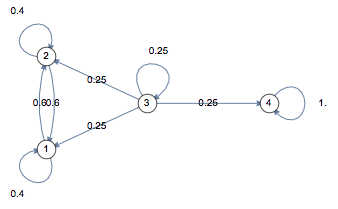

In [8]:
Image("/Users/Yvonne/Research/mbp/markov-chain.png")

In [9]:
#===========
#Geometric Clustering
#===========
clunum=500
cl=coor.cluster_kmeans(data=md_trajs,k=clunum,max_iter=20)
md_dtrajs = cl.dtrajs

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


13-11-18 17:05:30 pyemma.coordinates.clustering.kmeans.KmeansClustering[0] INFO     Cluster centers converged after 10 steps.


Widget Javascript not detected.  It may not be installed or enabled properly.


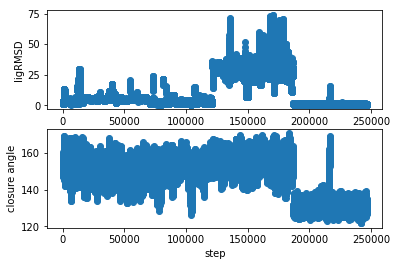

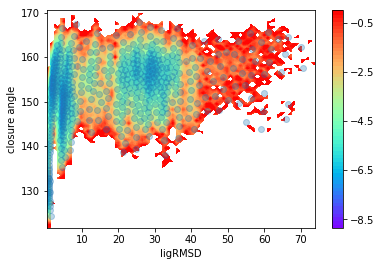

In [10]:
dim1=0
dim2=1
dataset=md_trajs
plt.subplot2grid((2, 1), (0, 0)) 
plt.plot(np.vstack(dataset)[:, dim1],linewidth=0,marker='o')
#plt.xlim(154000,156000)
plt.ylabel('ligRMSD')
plt.subplot2grid((2, 1), (1, 0))
plt.plot(np.vstack(dataset)[:, dim2],linewidth=0,marker='o')
#plt.xlim(154000,156000)
plt.ylabel('closure angle')
plt.xlabel('step')
plt.show()

# histogram data
z_,x_,y_ = np.histogram2d(np.vstack(dataset)[:, dim1], np.vstack(dataset)[:, dim2], bins=80)
# compute free energies
F_ = -np.log(z_)
# contour plot
extent_ = [x_[0], x_[-1], y_[0], y_[-1]]
contourf(F_.T, 60, cmap=plt.cm.rainbow, extent=extent_)
xlabel('ligRMSD'); ylabel('closure angle')
plt.xticks(range(0,80,10))
colorbar(ticks=[-8.5,-6.5,-4.5,-2.5,-0.5])

cc_x = cl.clustercenters[:,dim1]
cc_y = cl.clustercenters[:,dim2]
plt.plot(cc_x,cc_y,linewidth=0,marker='o',alpha=0.3)

In [11]:
#===========
#MSM Estimation
#===========
lags=[1,2,5,10,20,50,80,100,120,140,160,180,200,220,240]
its = msm.timescales_msm(md_dtrajs, lags=lags,nits=20)

Widget Javascript not detected.  It may not be installed or enabled properly.


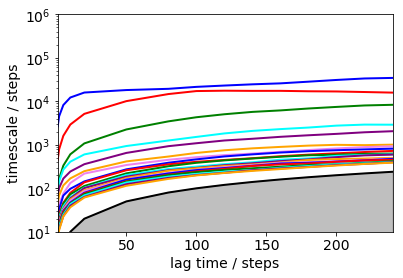

In [12]:
matplotlib.rcParams.update({'font.size': 14})
mplt.plot_implied_timescales(its, units='steps', linewidth=2)
xlim(1, 240); ylim(10, 10e+5);
#savefig('./its.png', bbox_inches='tight')
plt.show()

In [13]:
lag_fix=200
M=msm.estimate_markov_model(md_dtrajs, lag_fix, dt_traj='0.1 ns')
print('fraction of states used =',M.active_state_fraction)
print('fraction of counts used =',M.active_count_fraction)

fraction of states used = 0.992
fraction of counts used = 0.9996348884381339


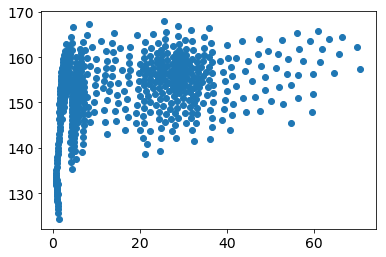

In [14]:
ccx=[]
ccy=[]
for i in M.active_set:
    ccx.append(cl.clustercenters[i,0])
    ccy.append(cl.clustercenters[i,1])

ccx=np.asarray(ccx)
ccy=np.asarray(ccy)

plt.plot(ccx,ccy,linewidth=0,marker='o')

[1.         0.99357411 0.9882137  0.97348197 0.93017959 0.89406833
 0.81869036 0.78479752 0.76639131 0.73067402]


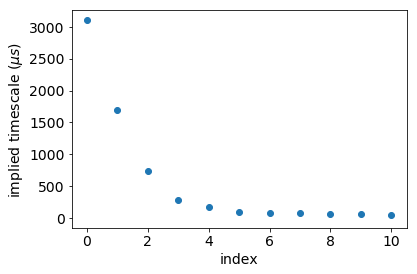

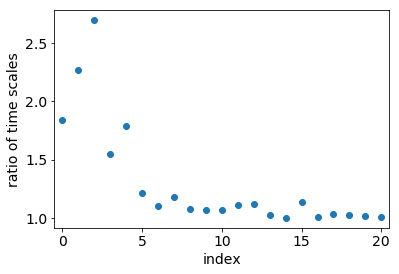

In [15]:
print(M.eigenvalues()[0:10])
plot(M.timescales(),linewidth=0,marker='o')
xlabel('index'); ylabel(r'implied timescale ($\mu s$)'); xlim(-0.5,10.5)
plt.show()

plot(M.timescales()[:-1]/M.timescales()[1:], linewidth=0,marker='o')
xlabel('index'); ylabel('ratio of time scales'); xlim(-0.5,20.5)
#savefig('./spectialgap-tica.png', bbox_inches='tight')
plt.show()

Calculate (un)binding rate
===

Step 1. Define metastable states, eg. unbound/bound state  
  
Step 2. Calculate mean first arrive time based on transition probability matrix  

Step 3. Rate=1/(mean first arrive time)

In [16]:
#===========
#Kinetic Clustering
#===========
nmacro=4
M_pcca=M.pcca(nmacro)

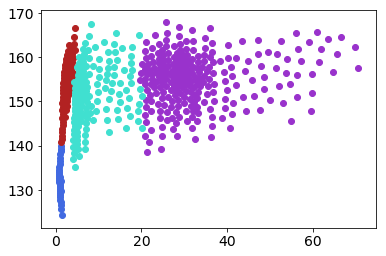

In [17]:
clr=['darkorchid','royalblue','firebrick','turquoise','orange','cyan','indigo','lavender']
for j in range(nmacro):
    for i in M_pcca.metastable_sets[j]:
        plt.scatter(ccx[i],ccy[i],color=clr[j])

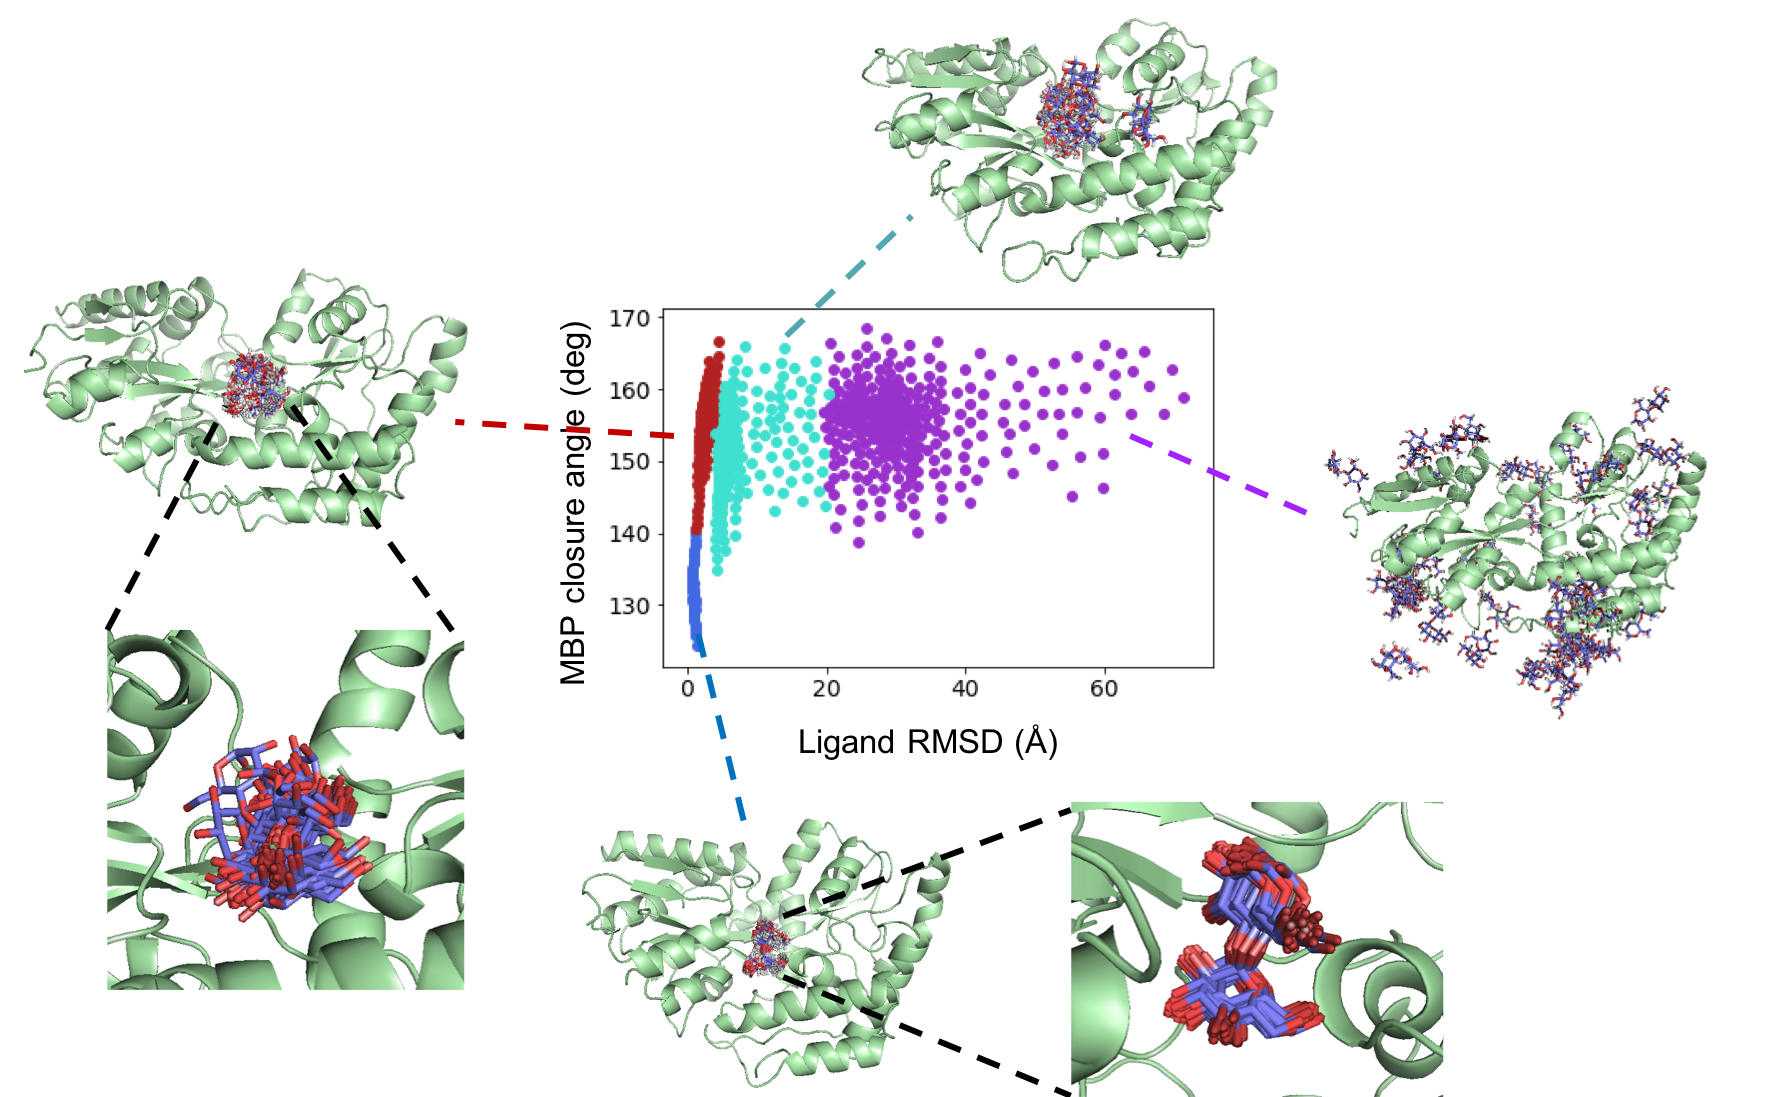

In [18]:
from IPython.display import display, Image
Image("/Users/Yvonne/Research/mbp/paper-figs/meta_struc_pcca.png")

In [19]:
#===========
#MFPT on/off rates
#===========
source=0
sink=1
Nsim = 19661.0  # number of water molecules in our simulation
Nstd = 55.55  # number of water molecules in standard volume
ligc = Nstd / Nsim

#prb(bound)/prb(unbound)
Keq=(M_pcca.coarse_grained_stationary_probability[sink]/M_pcca.coarse_grained_stationary_probability[source])/ligc
Kd=1/Keq
G=0.6*np.log(Kd)
print('disociation constant Kd =', Kd*10**6, 'uM')
print('binding free energy G =',G,'kcal/mol')

ton=M.mfpt(M_pcca.metastable_sets[source],M_pcca.metastable_sets[sink])
toff=M.mfpt(M_pcca.metastable_sets[sink],M_pcca.metastable_sets[source])

kon=10**9/(ligc*ton) #unit  M-1s-1
koff=10**9/(toff) #unit s-1
print('ton=',ton,'toff=',toff)
print('association constant kon =', kon*10**(-7), '*10e+7 M-1s-1')
print('dissociation constant koff =', koff, 's-1')
print('koff/kon =', (koff/kon)*10**6, 'uM')

disociation constant Kd = 79.99597380051635 uM
binding free energy G = -5.6601205512302455 kcal/mol
ton= 13906.898108599515 toff= 257287.81080045813
association constant kon = 2.545020396176445 *10e+7 M-1s-1
dissociation constant koff = 3886.697923577728 s-1
koff/kon = 152.71775147330746 uM


PCA analysis
==

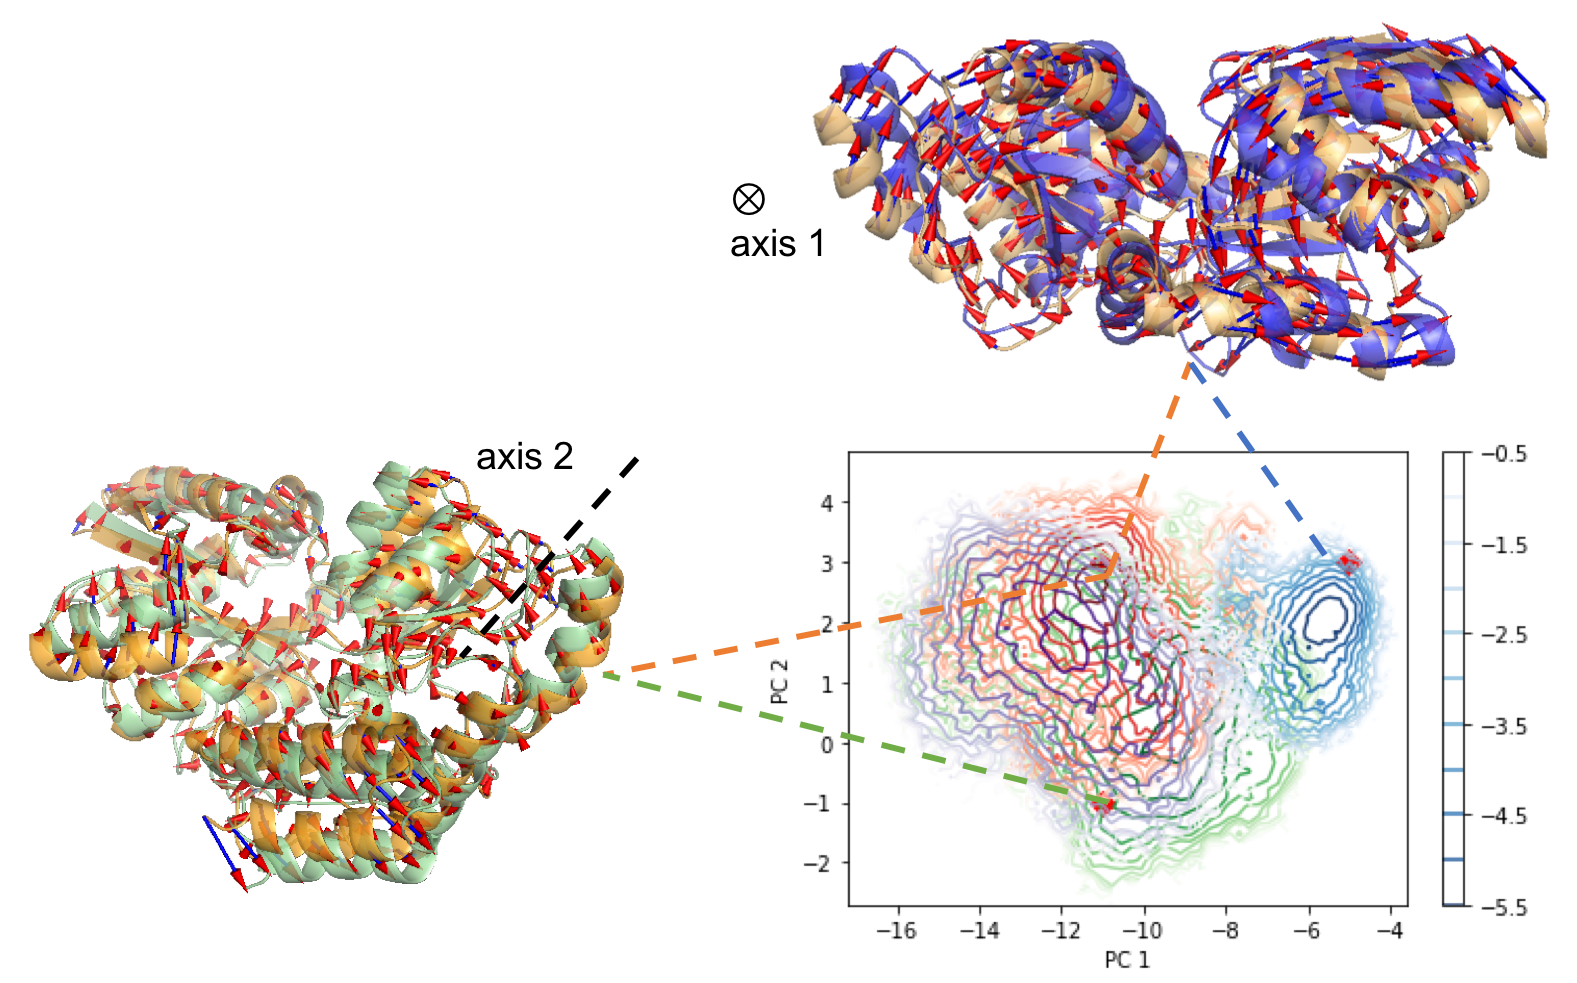

In [20]:
Image("/Users/Yvonne/Research/mbp/paper-figs/pca_struc.png")